# Assignment 2 - Q-Learning and Expected Sarsa

Welcome to Course 2 Programming Assignment 2. In this notebook, you will:

1. Implement Q-Learning with $\epsilon$-greedy action selection
2. Implement Expected Sarsa with $\epsilon$-greedy action selection
3. Investigate how these two algorithms behave on Cliff World (described on page 132 of the textbook)

We will provide you with the environment and infrastructure to run an experiment (called the experiment program in RL-Glue). This notebook will provide all the code you need to run your experiment and visualise learning performance.

This assignment will be graded automatically by comparing the behavior of your agent to our implementations of Expected Sarsa and Q-learning. The random seed will be set to avoid different behavior due to randomness. We will highlight the functions you have to use for generating random samples and the number of times these functions should be called. 

## Packages

You will need the following libraries for this assignment. We are using:
1. numpy: the fundamental package for scientific computing with Python.
2. scipy: a Python library for scientific and technical computing.
3. matplotlib: library for plotting graphs in Python.
4. RL-Glue: library for reinforcement learning experiments.

RL-Glue (Reinforcement Learning Glue) là một framework tiêu chuẩn giúp kết nối agent (tác nhân) và environment (môi trường) trong học tăng cường (Reinforcement Learning - RL). Nó giúp tổ chức các thí nghiệm RL một cách linh hoạt, đơn giản hóa việc triển khai và thử nghiệm nhiều thuật toán khác nhau.

DO NOT IMPORT OTHER LIBRARIES - This will break the autograder.

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import sem

from rl_glue import RLGlue
from agent import BaseAgent
import cliffworld_env

In [18]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10,5]})

## Q-Learning

In this section you will implement and test a Q-Learning agent with $\epsilon$-greedy action selection (Section 6.5 in the textbook). 

Q-learning là một thuật toán **off-policy**, cập nhật giá trị \(Q(s, a)\) dựa trên hành động tốt nhất có thể tại trạng thái tiếp theo, thay vì hành động thực tế đã được chọn.

$$ Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma \max_{a} Q(S_{t+1}, a) - Q(S_t, A_t) \right] $$

Trong đó:
- **\( \alpha \)**: Tốc độ học (learning rate).
- **\( \gamma \)**: Hệ số chiết khấu (discount factor).
- **\( R_{t+1} \)**: Phần thưởng nhận được sau hành động \(A_t\).
- **\( Q(S_t, A_t) \)**: Giá trị hành động tại trạng thái hiện tại.
- **\( Q(S_{t+1}, A_{t+1}) \)**: Giá trị hành động của trạng thái tiếp theo, theo chính sách hiện tại.

### Implementation

Your job is to implement the updates in the methods agent_step and agent_end. We provide detailed comments in each method describing what your code should do.

In [ ]:
# -----------
# Graded Cell
# -----------

class QLearningAgent:
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts."""
        # Store the parameters provided in agent_init_info
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"]) #Một giá trị khởi tạo cho bộ sinh số ngẫu nhiên, Để kết quả ngẫu nhiên có thể tái lập.

        
        # Initialize Q-table to zero
        self.q = np.zeros((self.num_states, self.num_actions))

    def agent_start(self, observation):
        """The first method called when the episode starts."""
        state = observation
        # Choose action using epsilon-greedy
        current_q = self.q[state, :] #Lấy toàn bộ giá trị Q của tất cả các hành động tại trạng thái state
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) #Exploration 
        else:
            action = self.argmax(current_q) #Exploitation
        
        self.prev_state = state
        self.prev_action = action
        return action

    def agent_step(self, reward, observation):
        """A step taken by the agent."""
        state = observation
        # Choose action using epsilon-greedy
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Perform Q-Learning update
        prev_state = self.prev_state
        prev_action = self.prev_action
        
        # Q-learning update rule
        self.q[prev_state, prev_action] += self.step_size * (
            reward + self.discount * np.max(self.q[state, :]) - self.q[prev_state, prev_action]
        )
        
        # Update state and action
        self.prev_state = state
        self.prev_action = action
        return action

    def agent_end(self, reward):
        """Run when the agent terminates."""
        # Perform the final Q-value update for the terminal state
        prev_state = self.prev_state
        prev_action = self.prev_action
        
        self.q[prev_state, prev_action] += self.step_size * (
            reward - self.q[prev_state, prev_action]
        )

    def argmax(self, q_values):
        """argmax with random tie-breaking."""
        max_value = np.max(q_values)
        ties = np.flatnonzero(q_values == max_value)
        return self.rand_generator.choice(ties)

### Test

Run the cells below to test the implemented methods. The output of each cell should match the expected output.

Note that passing this test does not guarantee correct behavior on the Cliff World.

In [ ]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

np.random.seed(0)

agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
agent = QLearningAgent()
agent.agent_init(agent_info)
action = agent.agent_start(0)

expected_values = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
])

assert np.all(agent.q == expected_values)
assert action == 1

# reset the agent
agent.agent_init(agent_info)

action = agent.agent_start(0)
assert action == 1

action = agent.agent_step(2, 1)
assert action == 3

action = agent.agent_step(0, 0)
assert action == 1

expected_values = np.array([
    [0.,  0.2,  0.,  0.  ],
    [0.,  0.,   0.,  0.02],
    [0.,  0.,   0.,  0.  ],
])
assert np.all(np.isclose(agent.q, expected_values))

# reset the agent
agent.agent_init(agent_info)

action = agent.agent_start(0)
assert action == 1

action = agent.agent_step(2, 1)
assert action == 3

agent.agent_end(1)

expected_values = np.array([
    [0.,  0.2, 0.,  0. ],
    [0.,  0.,  0.,  0.1],
    [0.,  0.,  0.,  0. ],
])
assert np.all(np.isclose(agent.q, expected_values))

# Run a few more tests to ensure the epsilon-random action is not picked in the update
expected_values = np.array([
    [0.,         0.2,        0.,         0.        ],
    [5.97824336, 5.75000715, 5.79372928, 6.69483878],
    [0.,         0.,         0.,         0.        ],
])
agent.epsilon = 1.0  # Set epsilon high so that there is a larger chance to catch the errors
for _ in range(100):
    agent.agent_step(2, 1)
assert np.all(np.isclose(agent.q, expected_values))

# Expected Sarsa

In this section you will implement an Expected Sarsa agent with $\epsilon$-greedy action selection (Section 6.6 in the textbook). 

**Sarsa** là một thuật toán **on-policy** cập nhật giá trị \(Q(s, a)\) dựa trên hành động thực tế mà chính sách \(\pi\) chọn tại bước tiếp theo.

Công thức cập nhật:

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) \right]
$$

--

**Expected Sarsa**

Expected Sarsa là một phiên bản nâng cao của Sarsa, sử dụng giá trị kỳ vọng của \(Q(s, a)\) thay vì giá trị của một hành động cụ thể.

Công thức cập nhật:

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma \sum_{a} \pi(a|S_{t+1}) Q(S_{t+1}, a) - Q(S_t, A_t) \right]
$$

**Điểm khác biệt với Sarsa**:
- Thay vì dùng \(Q(S_{t+1}, A_{t+1})\), Expected Sarsa sử dụng **giá trị kỳ vọng có trọng số** của tất cả các hành động tại \(S_{t+1}\), theo xác suất của chính sách \(\pi(a | S_{t+1})\).

### Implementation

Your job is to implement the updates in the methods agent_step and agent_end. We provide detailed comments in each method describing what your code should do.

In [ ]:
# -----------
# Graded Cell
# -----------

class ExpectedSarsaAgent:
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts."""
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        # Initialize action-value table (Q-table) to zeros
        self.q = np.zeros((self.num_states, self.num_actions))

    def epsilon_greedy_action(self, state):
        """Select an action using epsilon-greedy policy."""
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            return self.rand_generator.randint(self.num_actions)
        return self.argmax(current_q)

    def agent_start(self, observation):
        """Start of the episode."""
        state = observation
        action = self.epsilon_greedy_action(state)
        self.prev_state = state
        self.prev_action = action
        return action

    def agent_step(self, reward, observation):
        """A step taken by the agent."""
        state = observation
        action = self.epsilon_greedy_action(state)
        
        # Compute the expected value of the next state
        current_q = self.q[state, :]
        max_q = np.max(current_q)
        pi = (
            np.ones(self.num_actions) * (self.epsilon / self.num_actions) +
            (current_q == max_q).astype(float) * (1 - self.epsilon) / np.sum(current_q == max_q)
        ) # Calculate the expected value of the next state
        expected_q = np.sum(pi * current_q)
        
        # Update Q-value for the previous state and action
        prev_state = self.prev_state
        prev_action = self.prev_action
        self.q[prev_state, prev_action] += self.step_size * (
            reward + self.discount * expected_q - self.q[prev_state, prev_action]
        )
        
        # Update previous state and action
        self.prev_state = state
        self.prev_action = action
        return action

    def agent_end(self, reward):
        """End of the episode."""
        prev_state = self.prev_state
        prev_action = self.prev_action
        self.q[prev_state, prev_action] += self.step_size * (
            reward - self.q[prev_state, prev_action]
        )

    def argmax(self, q_values):
        """Argmax with random tie-breaking."""
        max_value = np.max(q_values)
        ties = np.flatnonzero(q_values == max_value)
        return self.rand_generator.choice(ties)

### Test

Run the cells below to test the implemented methods. The output of each cell should match the expected output.

Note that passing this test does not guarantee correct behavior on the Cliff World.

In [8]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
agent = ExpectedSarsaAgent()
agent.agent_init(agent_info)

action = agent.agent_start(0)
assert action == 1

expected_values = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
])
assert np.all(agent.q == expected_values)

# ---------------
# test agent step
# ---------------

action = agent.agent_step(2, 1)
assert action == 3

action = agent.agent_step(0, 0)
assert action == 1

expected_values = np.array([
    [0, 0.2, 0, 0],
    [0, 0, 0, 0.0185],
    [0, 0, 0, 0],
])
assert np.all(np.isclose(agent.q, expected_values))

# --------------
# test agent end
# --------------

agent.agent_end(1)

expected_values = np.array([
    [0, 0.28, 0, 0],
    [0, 0, 0, 0.0185],
    [0, 0, 0, 0],
])
assert np.all(np.isclose(agent.q, expected_values))

# Solving the Cliff World

Chúng tôi đã mô tả môi trường Cliff World trong video "Expected Sarsa in the Cliff World" ở Bài 3. Đây là một nhiệm vụ theo từng phần không được giảm giá và do đó chúng tôi đặt $\gamma$=1. Tác nhân bắt đầu ở góc dưới bên trái của gridworld bên dưới và thực hiện các hành động di chuyển nó theo bốn hướng. Các hành động di chuyển tác nhân ra khỏi vách đá sẽ phải chịu phần thưởng là -100 và đưa tác nhân trở lại trạng thái bắt đầu. Phần thưởng cho tất cả các lần chuyển đổi khác là -1. Một tập kết thúc khi tác nhân đến góc dưới bên phải.

<img src="cliffworld.png" alt="Drawing" style="width: 600px;"/>


Sử dụng chương trình thử nghiệm trong ô bên dưới, chúng ta sẽ so sánh các tác nhân trên môi trường Cliff World và vẽ biểu đồ tổng phần thưởng trong mỗi tập cho hai tác nhân.

Kết quả của ô này sẽ được chấm điểm. Nếu bạn thực hiện bất kỳ thay đổi nào đối với thuật toán của mình, bạn phải chạy lại ô này trước khi nộp bài tập.

100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


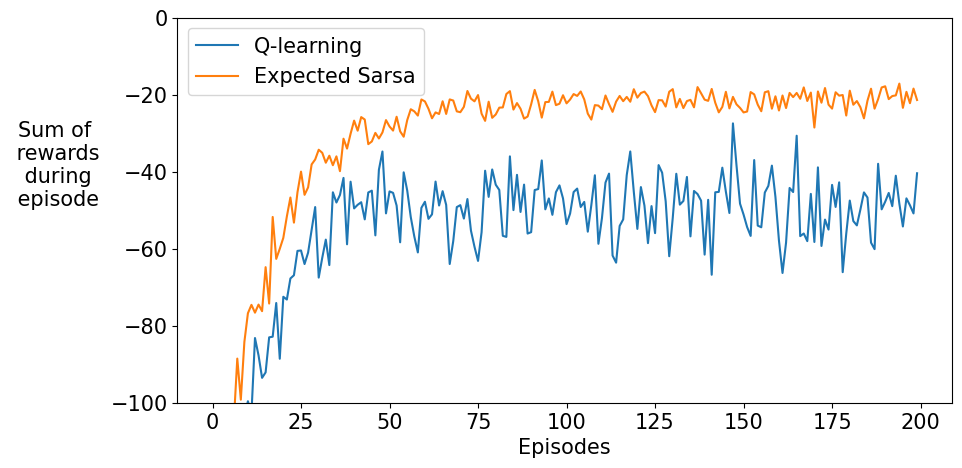

In [ ]:
# ---------------
# Discussion Cell
# ---------------
np.random.seed(0) #Đặt seed ngẫu nhiên cố định để đảm bảo kết quả có thể tái lập.

agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
env = cliffworld_env.Environment
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0}
env_info = {}
num_runs = 100 # The number of runs
num_episodes = 200 # The number of episodes in each run

for algorithm in ["Q-learning", "Expected Sarsa"]:
    all_reward_sums[algorithm] = [] #Tổng số điểm thưởng trong mỗi episode
    all_state_visits[algorithm] = [] #Lượt truy cập trạng thái trong 10 episode cuối cùng
    for run in tqdm(range(num_runs)):
        agent_info["seed"] = run
        rl_glue = RLGlue(env, agents[algorithm])
        rl_glue.rl_init(agent_info, env_info)

        reward_sums = []
        state_visits = np.zeros(48) #Đếm số lần agent ghé qua mỗi trạng thái
        for episode in range(num_episodes):
            if episode < num_episodes - 10:
                # Runs an episode
                rl_glue.rl_episode(10000) 
            else: 
                # Runs an episode while keeping track of visited states
                state, action = rl_glue.rl_start()
                state_visits[state] += 1
                is_terminal = False
                while not is_terminal:
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    state_visits[state] += 1
                
            reward_sums.append(rl_glue.rl_return())
            
        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)

# plot results
for algorithm in ["Q-learning", "Expected Sarsa"]:
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.ylim(-100,0)
plt.legend()
plt.show()

Để xem lý do tại sao hai tác nhân này lại hành xử khác nhau, hãy cùng kiểm tra các trạng thái mà chúng ghé thăm nhiều nhất. Chạy ô bên dưới để tạo biểu đồ hiển thị số bước thời gian mà các tác nhân đã dành ở mỗi trạng thái trong 10 tập gần đây nhất.

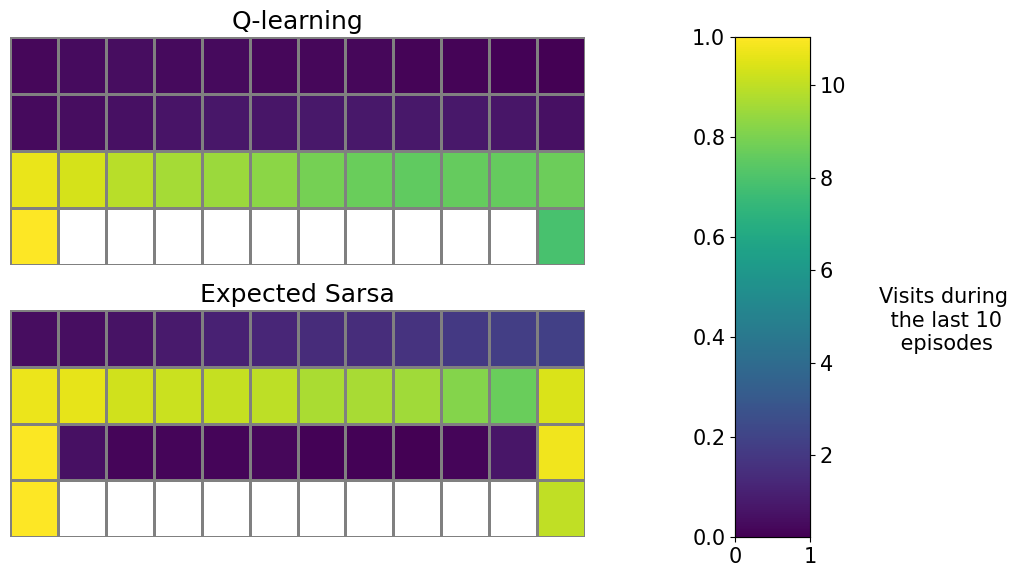

In [13]:
# ---------------
# Discussion Cell
# ---------------

for algorithm, position in [("Q-learning", 211), ("Expected Sarsa", 212)]:
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[algorithm]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((4,12))
    grid_state_visits[0,1:-1] = np.nan
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2)
    plt.title(algorithm)
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([0.85, 0.0, 0.075, 1.])
    
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Visits during\n the last 10\n episodes", rotation=0, labelpad=70)
plt.show()

Tác nhân Q-learning học chính sách tối ưu, chính sách di chuyển dọc theo vách đá và đạt được mục tiêu trong càng ít bước càng tốt. Tuy nhiên, vì tác nhân không tuân theo chính sách tối ưu và sử dụng khám phá $\epsilon$-tham lam, nên đôi khi nó rơi khỏi vách đá. Tác nhân Expected Sarsa tính đến việc khám phá và đi theo một con đường an toàn hơn.

Trước đây, chúng tôi đã sử dụng kích thước bước cố định là 0,5 cho các tác nhân. Điều gì xảy ra với các kích thước bước khác? Sự khác biệt về hiệu suất này có tồn tại không?

Trong thử nghiệm tiếp theo, chúng tôi sẽ thử 10 kích thước bước khác nhau từ 0,1 đến 1,0 và so sánh tổng phần thưởng cho mỗi tập trung bình trong 100 tập đầu tiên (tương tự như các đường cong hiệu suất tạm thời trong Hình 6.3 của sách giáo khoa). Các vùng tô bóng hiển thị lỗi chuẩn.

Ô này mất khoảng 10 phút để chạy. Kết quả của ô này sẽ được chấm điểm. Nếu bạn thực hiện bất kỳ thay đổi nào đối với thuật toán của mình, bạn phải chạy lại ô này trước khi nộp bài tập.

100%|██████████| 600/600 [02:06<00:00,  4.76it/s]


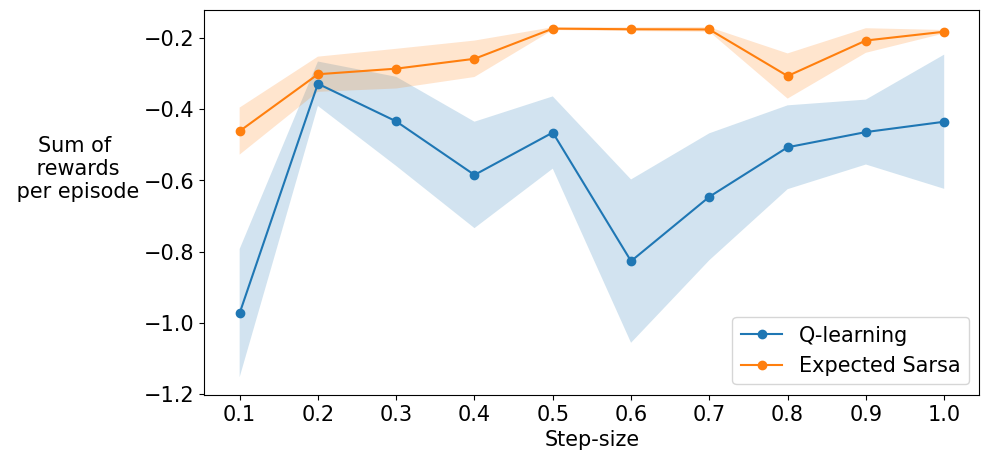

In [14]:
# ---------------
# Discussion Cell
# ---------------
from itertools import product

agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
env = cliffworld_env.Environment
all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "discount": 1.0}
env_info = {}
num_runs = 30
num_episodes = 100
all_reward_sums = {}

algorithms = ["Q-learning", "Expected Sarsa"]
cross_product = list(product(algorithms, step_sizes, range(num_runs)))
for algorithm, step_size, run in tqdm(cross_product):
    if (algorithm, step_size) not in all_reward_sums:
        all_reward_sums[(algorithm, step_size)] = []

    agent_info["step_size"] = step_size
    agent_info["seed"] = run
    rl_glue = RLGlue(env, agents[algorithm])
    rl_glue.rl_init(agent_info, env_info)

    last_episode_total_reward = 0
    for episode in range(num_episodes):
        rl_glue.rl_episode(0)
    all_reward_sums[(algorithm, step_size)].append(rl_glue.rl_return()/num_episodes)
        

for algorithm in ["Q-learning", "Expected Sarsa"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()

Expected Sarsa shows an advantage over Q-learning in this problem across a wide range of step-sizes.

Congratulations! Now you have:

- implemented Q-Learning with $\epsilon$-greedy action selection
- implemented Expected Sarsa with $\epsilon$-greedy action selection
- investigated the behavior of these two algorithms on Cliff World